In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib ipympl
from pianoq.lab.lee_holo.generate_lee import main, make_oam_donut, orthogonal_lee
import matplotlib.pyplot as plt 
from pianoq.lab.dmd import DMD
from pianoq.lab.VimbaCamera import VimbaCamera
from pianoq.lab.scripts.live_camera import live_cam
from pianoq.misc.mplt import mimshow
from pianoq.misc.borders import Borders
import numpy as np 
from pianoq.misc.misc import colorize
from matplotlib.animation import FuncAnimation


"""
G:/My Drive/Equipment (Specs, Drivers, Manuals)/Ajile DMD/dlp4500.pdf
dx_DMD = 7.637e-6
dx_cam = 4.8e-6
laser wl = 633e-9
f1=100e-3 #mm 
f2=40e-3 #mm 
"""

'\nG:/My Drive/Equipment (Specs, Drivers, Manuals)/Ajile DMD/dlp4500.pdf\ndx_DMD = 7.637e-6\ndx_cam = 4.8e-6\nlaser wl = 633e-9\nf1=100e-3 #mm \nf2=40e-3 #mm \n'

In [2]:
# Initialize hardware
cam = VimbaCamera(0)
dmd = DMD()

INFO:vmbpyLog:Starting vmbpy: 1.0.4 (using VmbC: 1.0.5, VmbImageTransform: 2.0)


Connected!
Built project!


C:\Users\owner\AppData\Local\Temp\ipykernel_8184\1068184319.py:44: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=interval)  # in ms


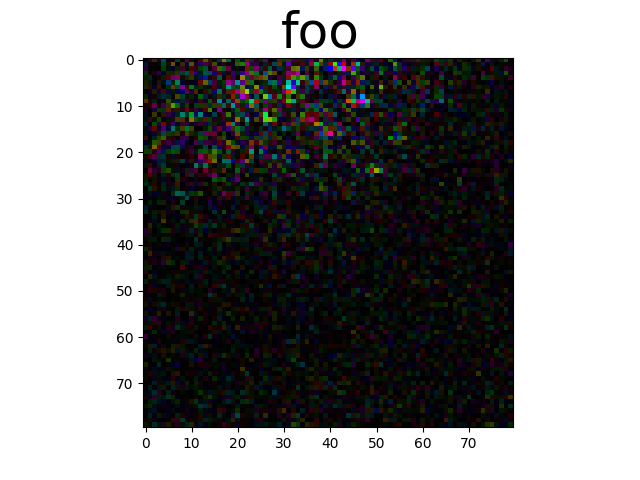

In [3]:
def live_lee(cam, interval=100, close_at_end=False, remove_min=True, cut_line=None, show_max=True, roi=None, **kwargs):
    """Live visualization of Lee hologram reconstruction"""
    if cut_line is None:
        fig, ax = plt.subplots()
    else:
        fig, axes = plt.subplots(2)
        ax = axes[0]
        ax_line = axes[1]
    if roi is not None:
        imm = cam.get_image(roi=roi)
    else:
        imm = cam.get_image()
    if remove_min:
        imm -= imm.min()
    E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imm)))
    cropped = E_k[420:500, 720:800]
    final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
    im = ax.imshow(colorize(final_field), vmax=2000)
    title = fig.suptitle('foo', fontsize=36)
    if cut_line is not None:
        line = ax_line.plot(imm[cut_line, :])
        line = line[0]

    def update(i):
        if roi is not None:
            imm = cam.get_image(roi=roi)
        else:
            imm = cam.get_image()
        if remove_min:
            imm -= imm.min()
        E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imm)))
        cropped = E_k[420:500, 720:800]
        final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
        im.set_data(colorize(final_field))
        if show_max:
            title.set_text(f'Max pixel: {imm.max():.3f}')
        else:
            title.set_text(f'Total power: {imm.sum():.3f}')
        ax.set_title('%03d' % i)
        if cut_line is not None:
            line.set_ydata(imm[cut_line, :])

    global ani
    ani = FuncAnimation(fig, update, interval=interval)  # in ms

    def close(event):
        if event.key == 'q':
            plt.close(event.canvas.figure)
            if close_at_end:
                cam.close()

    cid = fig.canvas.mpl_connect("key_press_event", close)
    plt.show(block=False)
live_lee(cam)

(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'final field'}>)

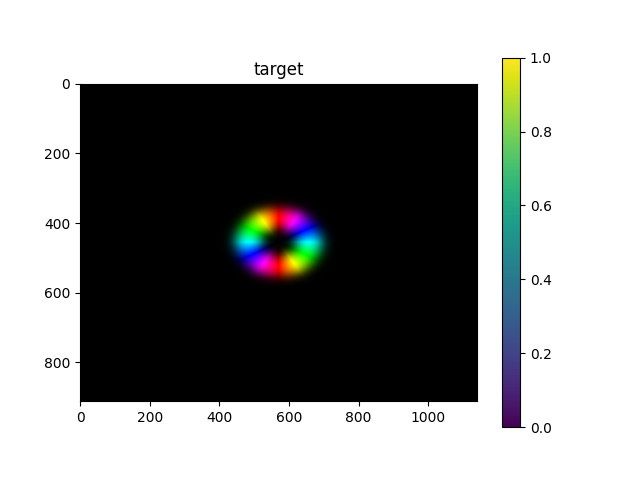

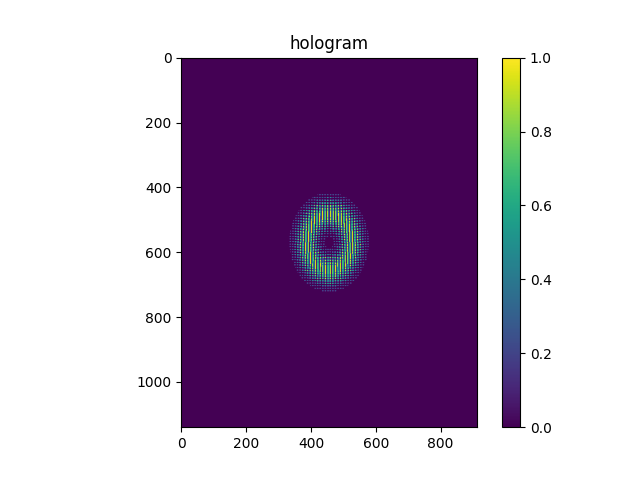

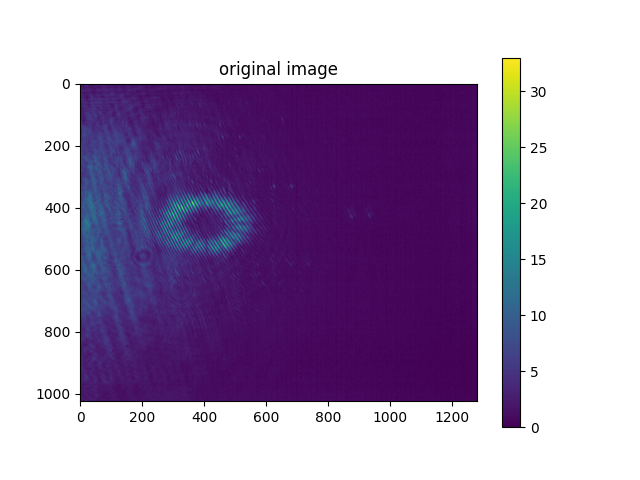

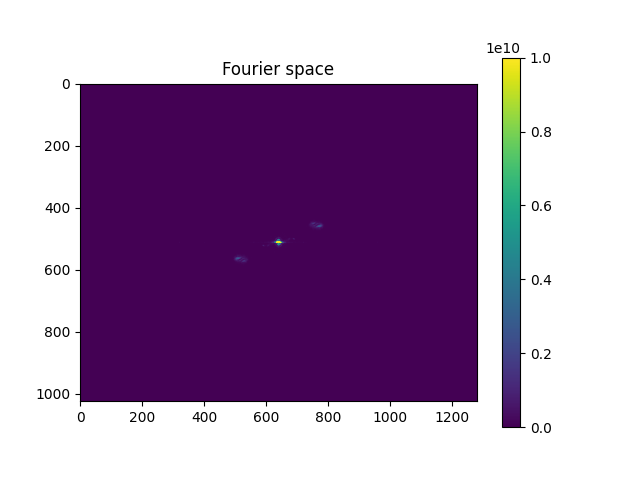

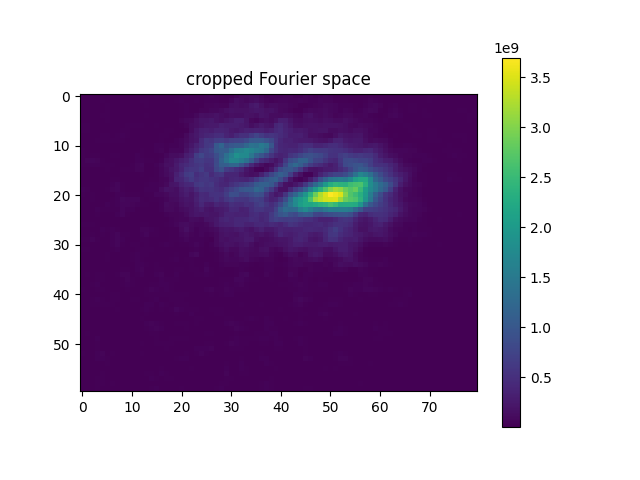

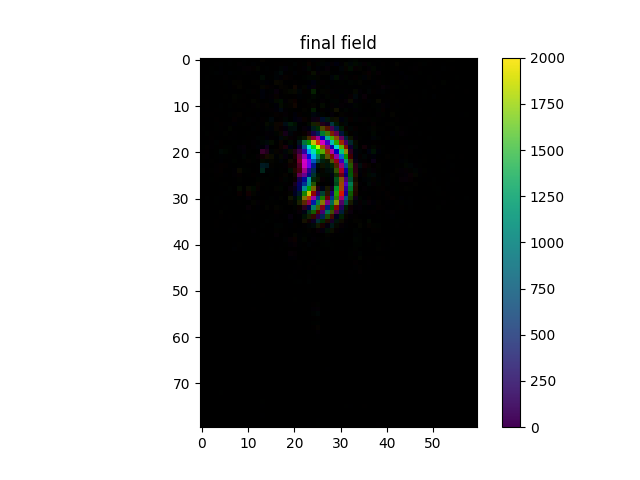

In [4]:
GRATING_PERIOD_PX = 8
CARRIER_F         = (1/GRATING_PERIOD_PX, 0)
target = make_oam_donut(Nx=dmd.Nx, Ny=dmd.Ny, ell=2, r0=0.15, sigma=0.05)
hologram, _ = orthogonal_lee(target, carrier_f=CARRIER_F, duty_cycle=0.5)
dmd.set_image(hologram.astype(bool))

mimshow(colorize(target), title='target', figshow=False)

cam.set_exposure_time(50)
im = cam.get_image()
E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im)))
mimshow(hologram, title='hologram', figshow=False)
mimshow(im, title='original image', figshow=False)
mimshow(np.abs(E_k)**2, vmax=1e10, title='Fourier space', figshow=False)
cropped = E_k[440:500, 720:800]
mimshow(np.abs(cropped)**2, figshow=False, title='cropped Fourier space')
final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
mimshow(colorize(final_field), vmax=2000, title='final field', figshow=False)

(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'final field'}>)

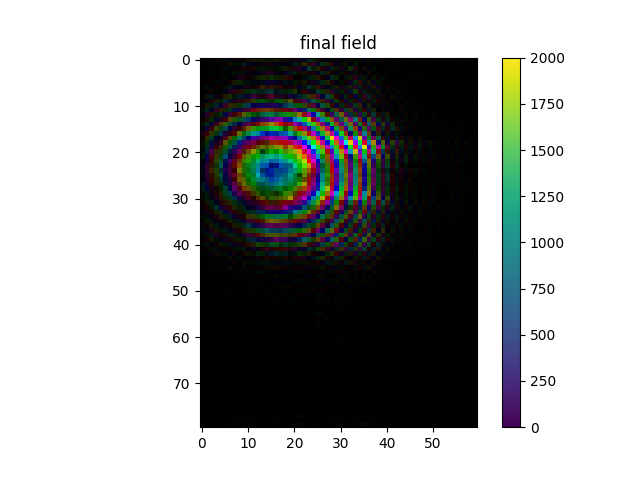

In [5]:
# Measure plane wave to get reference phase
GRATING_PERIOD_PX = 8
CARRIER_F = (1/GRATING_PERIOD_PX, 0)
target = np.ones((1140, 912))
hologram, _ = orthogonal_lee(target, carrier_f=CARRIER_F, duty_cycle=0.5)
dmd.set_image(hologram.astype(bool))

cam.set_exposure_time(50)
im = cam.get_image()
E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im)))
cropped = E_k[440:500, 720:800]
final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
mimshow(colorize(final_field), vmax=2000, title='final field', figshow=False)


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'cropped Fourier space'}>)

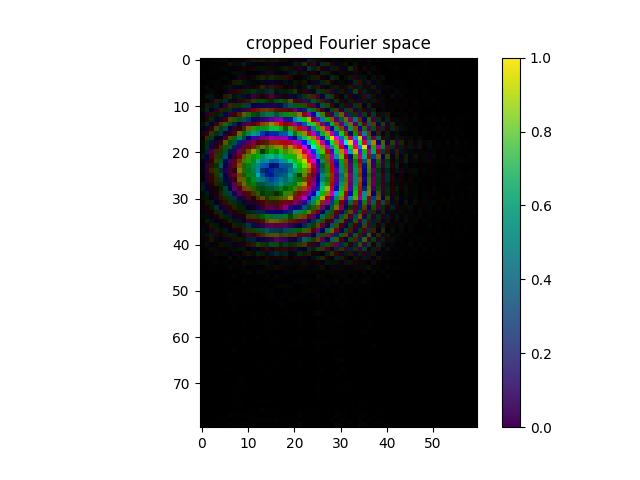

In [6]:
# Save reference phase
sqr_phase_field = final_field.copy()
mimshow(colorize(sqr_phase_field), figshow=False, title='cropped Fourier space')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'final field ell=2'}>)

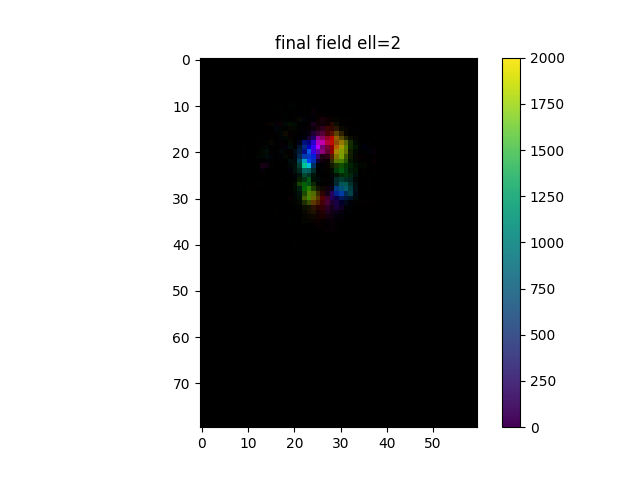

In [7]:
# Measure OAM with phase correction
GRATING_PERIOD_PX = 8
CARRIER_F = (1/GRATING_PERIOD_PX, 0)
ell_val = 2
target = make_oam_donut(Nx=dmd.Nx, Ny=dmd.Ny, ell=ell_val, r0=0.15, sigma=0.05)
hologram, _ = orthogonal_lee(target, carrier_f=CARRIER_F, duty_cycle=0.5)
dmd.set_image(hologram.astype(bool))

cam.set_exposure_time(50)
im = cam.get_image()
E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im)))
cropped = E_k[440:500, 720:800]
final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
mimshow(colorize(final_field * np.conjugate(sqr_phase_field)), vmax=2000, title=f'final field ell={ell_val}', figshow=False)


C:\Users\owner\AppData\Local\Temp\ipykernel_8184\3178471907.py:44: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=interval)  # in ms


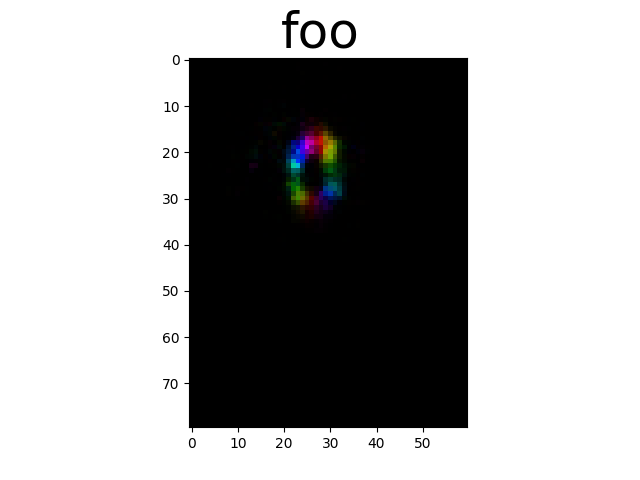

In [8]:
def live_lee2(cam, interval=100, close_at_end=False, remove_min=True, cut_line=None, show_max=True, roi=None, **kwargs):
    """Live visualization of Lee hologram reconstruction"""
    if cut_line is None:
        fig, ax = plt.subplots()
    else:
        fig, axes = plt.subplots(2)
        ax = axes[0]
        ax_line = axes[1]
    if roi is not None:
        imm = cam.get_image(roi=roi)
    else:
        imm = cam.get_image()
    if remove_min:
        imm -= imm.min()
    E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imm)))
    cropped = E_k[440:500, 720:800]
    final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
    im = ax.imshow(colorize(final_field * np.conjugate(sqr_phase_field)), vmax=2000)
    title = fig.suptitle('foo', fontsize=36)
    if cut_line is not None:
        line = ax_line.plot(imm[cut_line, :])
        line = line[0]

    def update(i):
        if roi is not None:
            imm = cam.get_image(roi=roi)
        else:
            imm = cam.get_image()
        if remove_min:
            imm -= imm.min()
        E_k = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imm)))
        cropped = E_k[440:500, 720:800]
        final_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(cropped)))
        im.set_data(colorize(final_field * np.conjugate(sqr_phase_field)))
        if show_max:
            title.set_text(f'Max pixel: {imm.max():.3f}')
        else:
            title.set_text(f'Total power: {imm.sum():.3f}')
        ax.set_title('%03d' % i)
        if cut_line is not None:
            line.set_ydata(imm[cut_line, :])

    global ani
    ani = FuncAnimation(fig, update, interval=interval)  # in ms

    def close(event):
        if event.key == 'q':
            plt.close(event.canvas.figure)
            if close_at_end:
                cam.close()

    cid = fig.canvas.mpl_connect("key_press_event", close)
    plt.show(block=False)
live_lee2(cam)

C:\code\pianoq\pianoq\lab\scripts\live_camera.py:52: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=interval)  # in ms


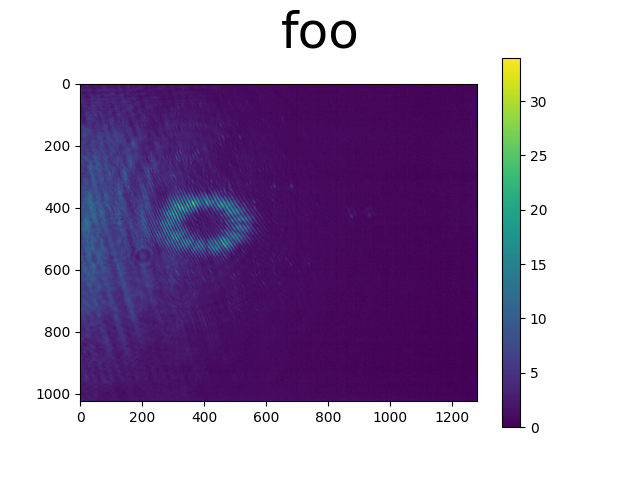

In [9]:
# cam.set_exposure_time(900)
live_cam(cam)

In [10]:
# Cleanup

## Close hardware connections (uncomment when done)
# dmd.close()
# cam.close()
